# Explolation03
## 집값데이터를 나만의 방법으로 전처리해보고 하이퍼파라미터를 설정해 집값을 예측해보고 캐글에올려 점수를 110000점이하로 받아보자.
### 일단 필요한 라이브러리를 가져오자.

In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#### 필요한 라이브러리를 가져왔으니 데이터를 가져오자.

In [11]:
data_dir = os.getenv('HOME')+"/aiffel/kaggle_kakr_housing/"

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')     
print(data_dir)
print(train_data_path)
print(sub_data_path)

/Users/janghan-yeong/aiffel/kaggle_kakr_housing/
/Users/janghan-yeong/aiffel/kaggle_kakr_housing/train.csv
/Users/janghan-yeong/aiffel/kaggle_kakr_housing/test.csv


In [12]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))


train data dim : (15035, 21)
test data dim : (6468, 20)


#### 트레인데이터는 약 1만5천개, 테스트 데이터는 약 6천개로 이루어져있으며, 테스트 데이터에는 price가 없기때문에 컬럼이 하나 적은 모습이 보여진다.

#### 이제 트레인 데이터와 테스트 데이터를 합쳐 결측치를 확인해주자.

In [13]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


In [14]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 약 2만1천개로 잘 합쳐진듯 보인다. 이제 결측치를 확인해주자.

<AxesSubplot:>

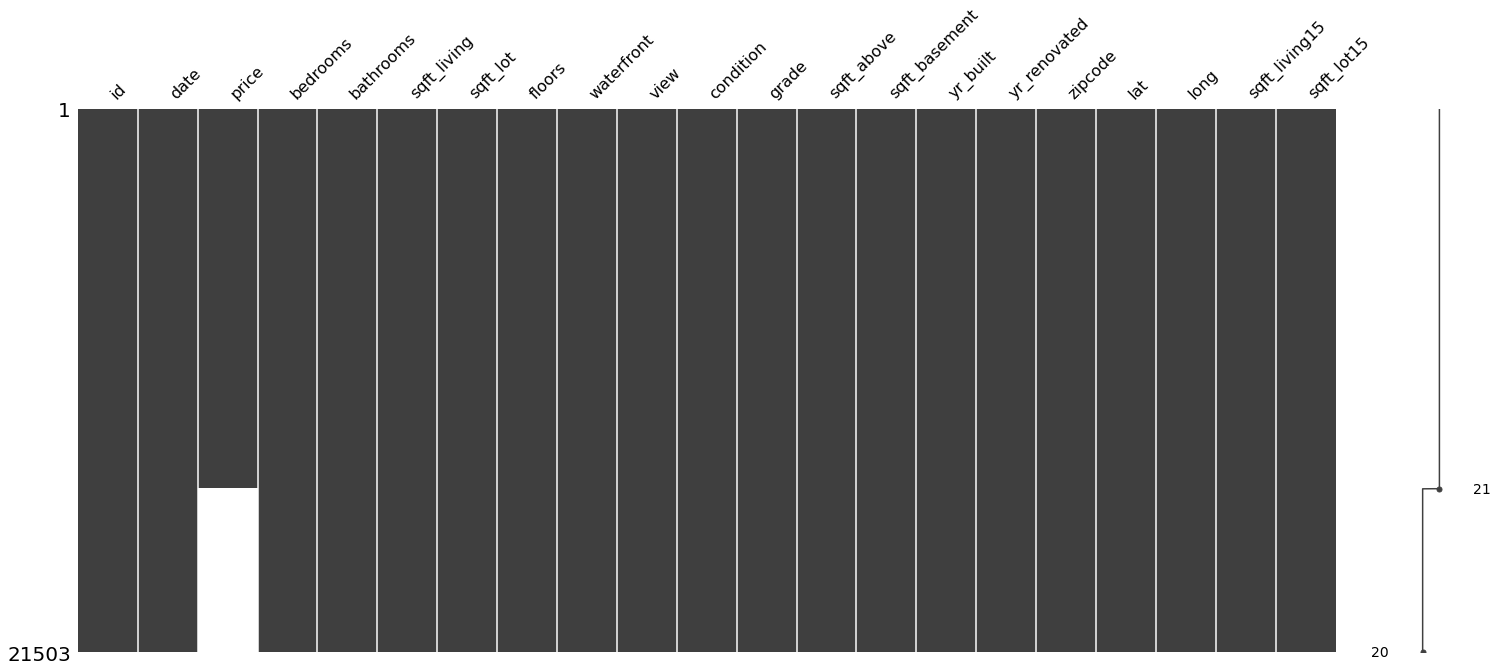

In [15]:
msno.matrix(data)

#### 테스트데이터에는 price컬럼이 없으므로 저렇게 빵꾸난것처럼 보일수가있다. 일단 그림으로봐서는 결측치가 없는것으로 보인다. 하지만 더 정확하게 결측치가있나 확인해보자.

In [16]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### 다행이 결측치는 없는걸로 보인다.
#### 이제 데이터들의 상관관계를 따져보자

In [17]:
train.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


#### 표로봐선 역시 보기가 힘드므로 그래프를 통해 한번 보도록하자.

##### 귀찮으니 함수로 만들어주자.

In [18]:
def scatter2 (n,i):
    plt.subplot(5,5,i+1)                
    plt.scatter(train[n], train['price'])
    plt.title(n+"-price")
    plt.ylabel('price')
    plt.xlabel(n)

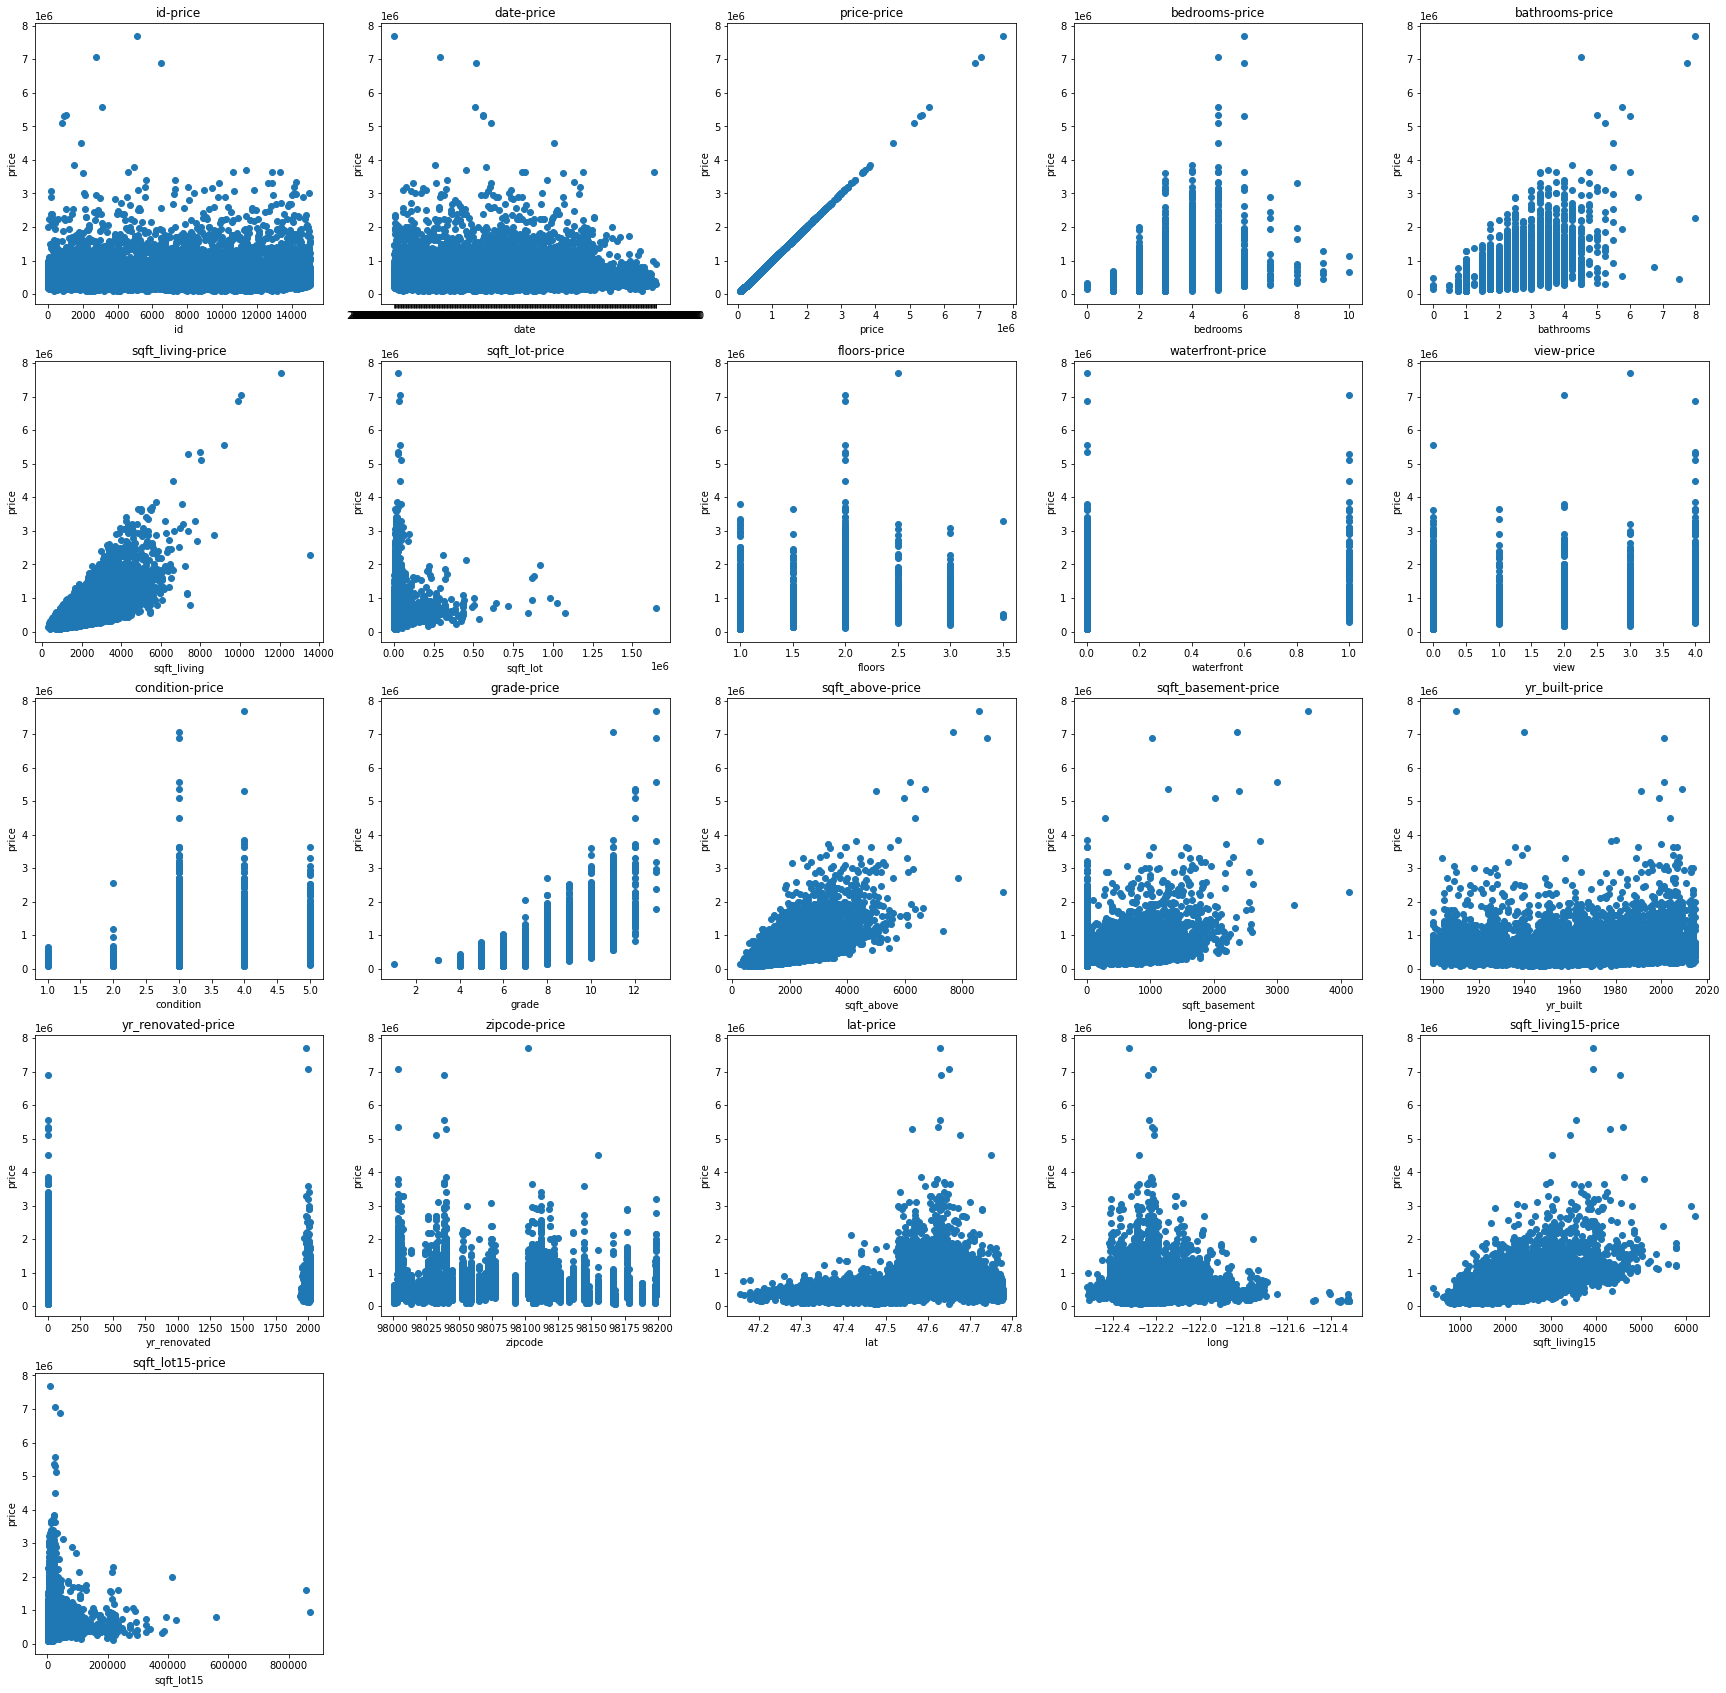

In [19]:
plt.figure(figsize=(30,30))
for i ,n in enumerate(train.columns):
    scatter2(i=i,n=n)
plt.show()

#### 데이터들을 보니 상관관계가 잘 확인된다.

#### 이제 데이터들의 이상치를 삭제해주자.

In [20]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

In [21]:

train_col = []
train_new = remove_out(train, train_col)


#### 사실 처음에 이상치를 제거해봤는데 score가 높게 나오길래 제거를 안해주고 해봤더니 score가 줄었다. 
#### 그래서 나의 생각은 이상치 제거를 할떄 정말 데이터 상관관계를 분석해 생각을 오래하고 이상치를 제거하는게 맞는것같다.
#### 아직 나는 데이터 전처리 실력이 많이 부족하므로 이상치는 제거해주지않았다.

In [22]:
train_new

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


#### 잘 삭제된것을 볼수있다.

In [23]:
train_new['date'] = train_new['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#### 그리고 테스트 데이터의 date를 int형으로 바꿔주었다.

In [24]:
train_new

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


#### y에 집값을 넣어주고 컬럼을 삭제해주었다. id도 삭제해주었다.

In [25]:
y = train_new['price']
del train_new['id']
del train_new['price']

In [26]:
del test['id']

#### 그리고 왼쪽으로 치우쳐진 데이터들은 로그변환을 해주었다. 마찬가지로 y값도 로그변환을 해주었다.

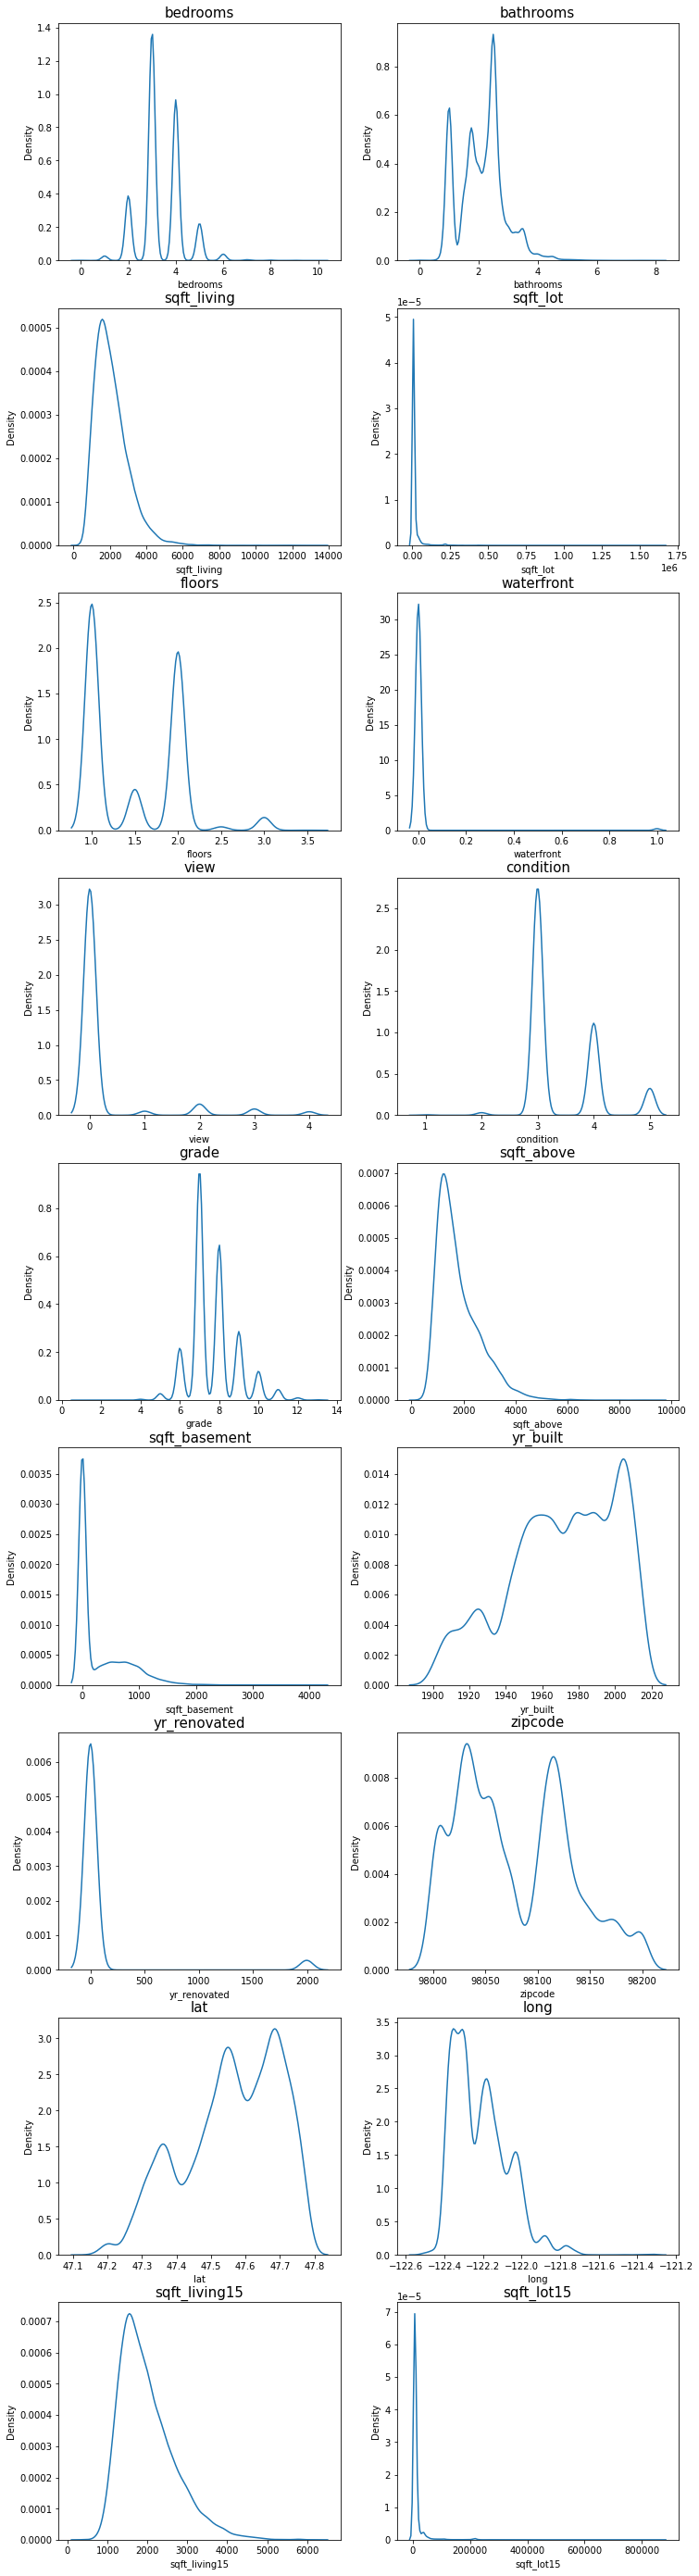

In [27]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   


count = 1
columns = train_new.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train_new[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [28]:
skew_columns = [ 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat',
       'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train_new[c] = np.log1p(train_new[c].values)
    test[c] = np.log1p(test[c].values)

#### 그리고 로그변환을 해주면서 한가지 실험을 해 보았다. 로그변환이 score점수에 영향을 많이 미치는가? 
#### 실험을 해보니 영향을 미치긴한다. 하지만 영향을 미치지않은 컬럼도 존재한다. 어찌됐든 로그변환을 해준다해서 부정적인 영향을 끼치지않는것을 확인했고
#### 로그 변환은 머리 비우고 해주는게 좋은것같다.

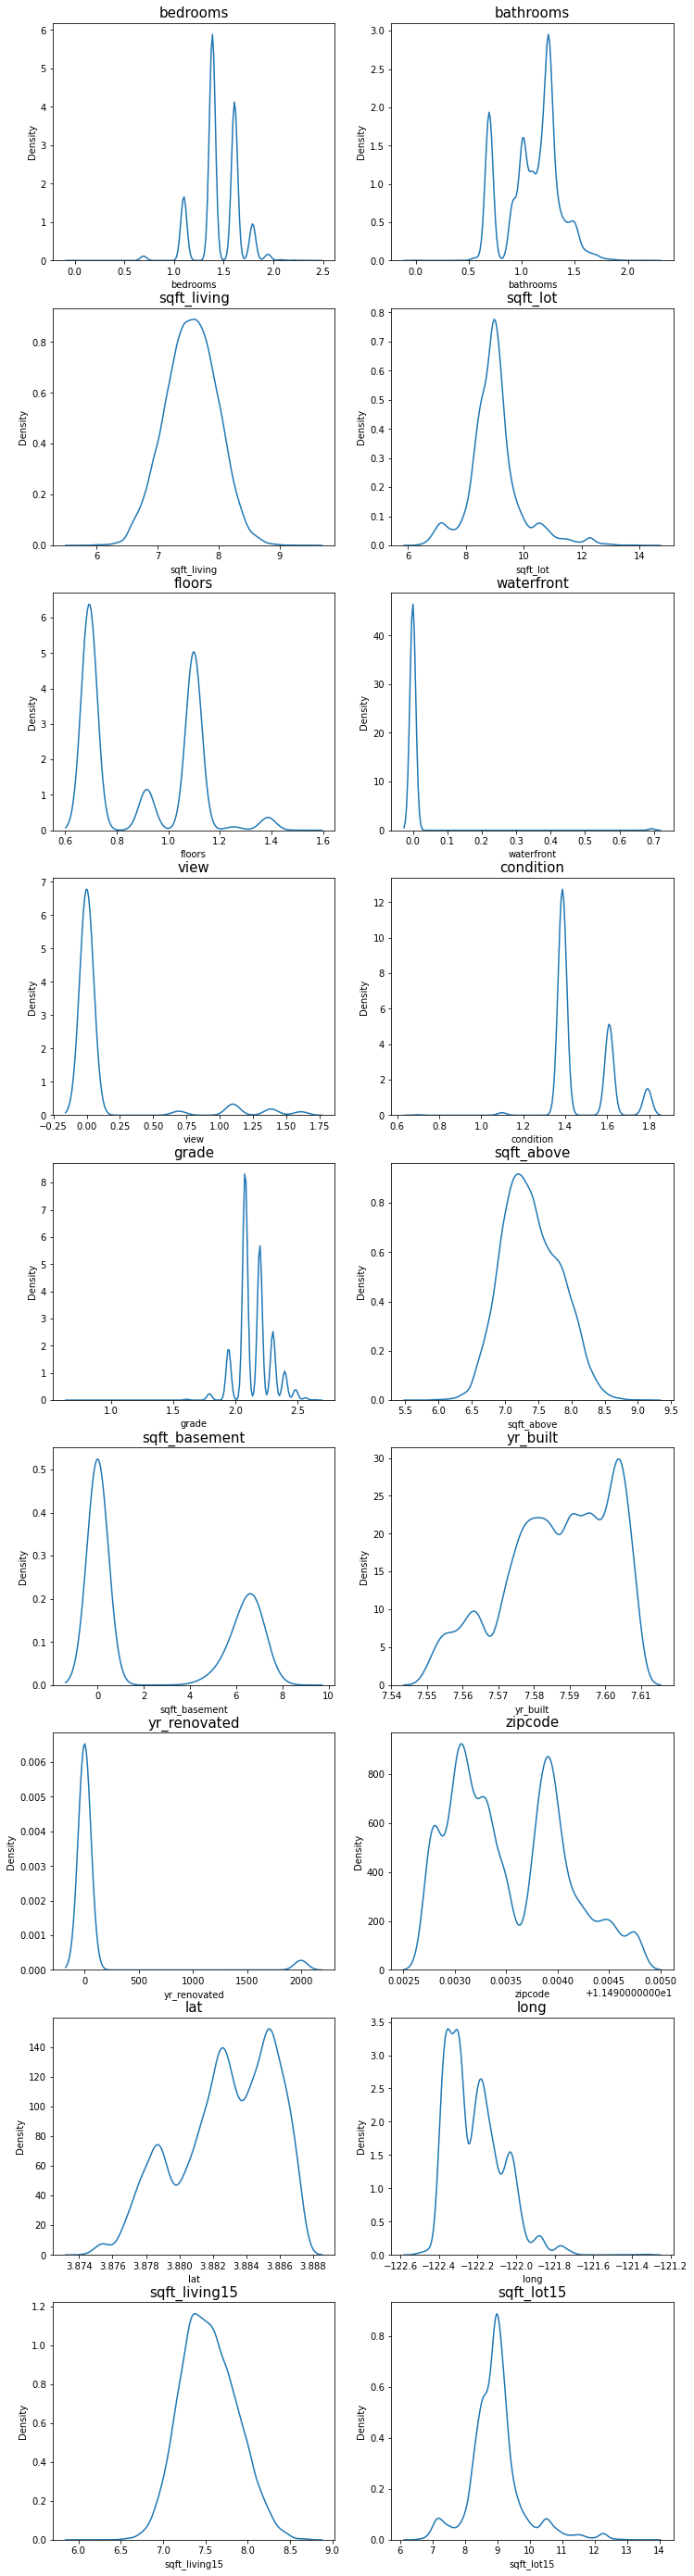

In [29]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  


count = 1
columns = train_new.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train_new[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

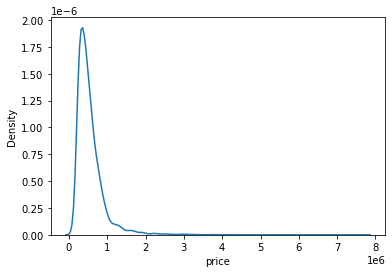

In [30]:
sns.kdeplot(y)
plt.show()

In [31]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

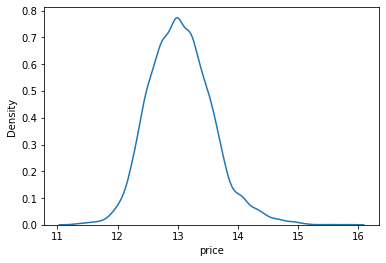

In [32]:
sns.kdeplot(y)
plt.show()

#### 이제 데이터의 준비가 다 끝났으니 학습을 시켜보자.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 어떤 모델이 가장 rmse값이 낮은지 보기위해 rmse함수를 만들어주었고 제일 좋은 결과를 나타내는 모델을 준비해 학습시킬 예정이다.

In [34]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### 내가 가져온 모델은 총 네개로 rmse값을 확인해보자.

In [35]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso


In [36]:
random_state=2020     

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)



models = [gboost, xgboost, lightgbm, rdforest]

#### LGBMRegressor 모델이 rmse가 가장 낮게나왔으므로 나는 이 모델을 가지고 서치그리드의 하이퍼파라미터를 조작해 더욱 결과가 좋게 만들것이다.

In [37]:
df = {}

for model in models:
    
    model_name = model.__class__.__name__

     
    X_train, X_test, y_train, y_test = train_test_split(train_new, y, random_state=random_state, test_size=0.2)

 
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)

   
    df[model_name] = rmse(y_test, y_pred)
    
   
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128370.48691059356,
 'XGBRegressor': 110343.28365784329,
 'LGBMRegressor': 111906.26808847864,
 'RandomForestRegressor': 125083.5859164711}

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    

    grid_model.fit(train, y)

   
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### 모델을 학습시키면서 파라미터를 설정할수있게 함수를 구현해봤다.

#### 이제 내가 하이퍼 파라미터를 조정해보면서 RMSE값을 내려볼것이다.

In [40]:
param_grid = {
        'max_depth': [10],
        'num_iterations':[9000],
      'learning_rate':[0.01],
      'num_leaves':[30]
}
model_lGB = LGBMRegressor(random_state=4950)
my_GridSearch(model_lGB, train_new, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/janghan-yeong/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/janghan-yeong/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/janghan-yeong/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/janghan-yeong/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".for

[CV] END learning_rate=0.01, max_depth=10, num_iterations=9000, num_leaves=30; total time=  17.1s
[CV] END learning_rate=0.01, max_depth=10, num_iterations=9000, num_leaves=30; total time=  17.2s
[CV] END learning_rate=0.01, max_depth=10, num_iterations=9000, num_leaves=30; total time=  17.2s
[CV] END learning_rate=0.01, max_depth=10, num_iterations=9000, num_leaves=30; total time=  17.3s
[CV] END learning_rate=0.01, max_depth=10, num_iterations=9000, num_leaves=30; total time=  17.3s


,learning_rate,max_depth,num_iterations,num_leaves,score,RMSLE
0,0.01,10,9000,30,-0.026161,0.161744


In [41]:
model_lGB2 = LGBMRegressor(random_state=random_state,
        max_depth= 10,
        learning_rate= 0.015,
        num_iterations=9000)

#### 하이퍼 파라미터 조작은 여기까지하고 이제 캐글에 내기위해 데이터를 변환후 저장해주자.

In [42]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+"/aiffel/kaggle_kakr_housing/"
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [43]:

save_submission(model_lGB2, train_new, y, test, 'LGB', rmsle='good3')


/Users/janghan-yeong/aiffel/kaggle_kakr_housing//submission_LGB_RMSLE_good3.csv saved!


<img src="https://github.com/JangHanYong/aiffel-report-Ex/blob/main/Explolation04/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-05-10%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.02.33.png?raw=true" width=2000 height=500>

#### 저장은 잘 되었고 캐글에 점수를 알아보니 11만점 밑으로 나왔다.
#### 이번 explolation03 과제를 해보면서 데이터 전처리가 정말 그 무엇보다도 중요하다는것을 느꼈다.
#### 그리고 하이퍼 파라미터의 영향이 작지않다. 라는것을 느꼈다. 여러모로 재밌는 노드였던것같다.